In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# Q1

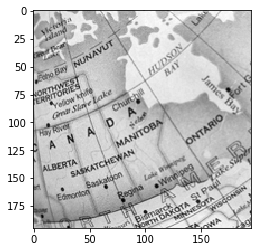

In [2]:
# Show the original image
img = cv2.imread('Globe.png',0)
plt.imshow(img, cmap='gray')

In [3]:
img.shape

(195, 195)

The shape of the image is (195,195). Therefore $N = 195$.<br>
$$σ(m,n) = A*e^{-\frac{\left(m-\frac{N}{2}\right)^{2} + \left(n-\frac{N}{2}\right)^{2}}{B}}$$
Given $σ(N/2, N/2) = 2.0$ <br>
From the equation given for $σ(m,n)$ we get,
$$A = σ(N/2,N/2) = 2.0$$

Also $σ(0,0) = A*e^{-N^{2}/2B}$. <br>
Substituting $N=195$ and $A = 2.0$, we get
$$B = 3588.403$$



In [4]:
# Define sigma function sig1(m,n)
def sig1(m,n):
    N = 195
    A = 2.0
    # Calculate B from A and N as shown above
    B = N*N/(2*np.log(A/0.01))
    # Use the sigma function given
    return A*np.exp(-((m-N/2)**2 + (n-N/2)**2)/(2*B))

# Function to compute the gaussian kernel given the value of sigma
def get_kernel(sigma):
    # n is the kernel size
    n = ceil(6*sigma + 1)
    # n=1 is a trivial case
    if n==1: return np.array([[1.]])
    # Make n odd
    if n%2==0:
        n+=1
    # Compute all the values of the gaussian kernel
    p = n//2
    kernel = np.zeros((n,n))
    for i in range(-p, p+1):
        for j in range(-p,p+1):
            kernel[p+i,p+j] = np.exp((-i**2-j**2)/(2*(sigma**2)))/(2*(sigma**2)*np.pi)
    
    kernel = kernel / np.sum(kernel)    
    return kernel

# Helper function for space variant blurring. 
# Used to compute blurred image given the image and sigma at all pixels
def space_var_blur_helper(img, sigma_all):
    (l,w) = img.shape
    # Create blank image
    blur_img = np.zeros(img.shape)
    for i in range(l):
        for j in range(w):
            # Find kernel at that point
            ker = get_kernel(sigma_all[i,j])
            ker = np.flip(ker, (0,1)) # Flipping the kernel through both axes
            sz = ker.shape[0]//2
            kernel_intensity = ker*img[i,j]
            # Superpose (image intensity * kernel) on to the blank image at that point
            for p in range(i-sz, i+sz+1):
                for q in range(j-sz, j+sz+1):
                    # Add to existing value if the coordinate is within the image bounds
                    if p>=0 and p<l and q>=0 and q<w:
                        blur_img[p,q]+=kernel_intensity[p-(i-sz),q-(j-sz)]
    # Return the blurred image
    return blur_img

def space_var_blur(img, sig = sig1):
    # Compute sigma for all pixels on image
    sigma_all = np.array([[sig(m,n) for n in range(img.shape[1])] for m in range(img.shape[0])])
    # Compute and return Space-Variant blurred image
    blurred_img = space_var_blur_helper(img, sigma_all=sigma_all)
    return blurred_img

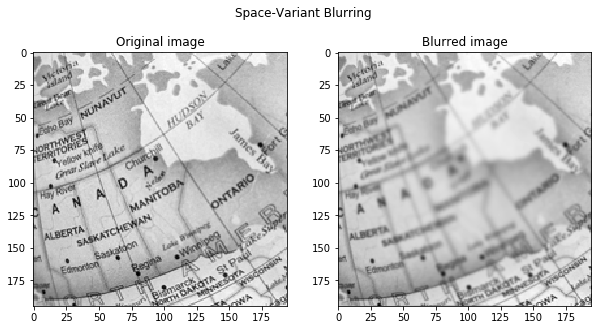

In [5]:
img = cv2.imread('Globe.png',0)
blurred_img = space_var_blur(img)

# Show the original and blurred images.
f, axs = plt.subplots(1, 2, figsize = (10,5))
plt.suptitle("Space-Variant Blurring")
axs[0].set_title("Original image")
axs[1].set_title("Blurred image")
axs[0].imshow(img,cmap='gray')
axs[1].imshow(blurred_img,cmap='gray')
plt.show()

# Q2

In [6]:
# Space invariant blur function used from previous assignment
# space_invariant_blur function returns the space invariant blurred image given a clear image and the 
# kernel size to be used for blurring
def space_invariant_blur(img, kernel):
    assert kernel.shape[0] == kernel.shape[1]
    kernel = np.flip(kernel, (0,1)) # Flipping the kernel through both axes 
    n = kernel.shape[0]
    (l,w) = img.shape
    assert n%2==1
    blur_img = np.zeros(img.shape)
    
    # For each i,j we superpose the flipped kernel on top of the image coordinate and multiply corresponding values
    # and add them. We also normalise each value by the kernel_sum since the sum of the kernel is assumed to be 1.
    # For the boundary values where part of the kernel lies outside the image, we will normalise only with the values 
    # in the kernel which lie within the image.
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            kernel_sum = 0
            intensity_sum = 0
            # Compute the sum of all the intensities around a particular coordinate multiplied by the corresponding 
            # kernel values. This is stored in intensity_sum. kernel_sum stores the sum of all kernel values which 
            # lie within the image.
            for k in range(i-n//2,i+n//2+1):
                for m in range(j-n//2, j+n//2+1):
                    if k<l and k>=0 and m<w and m>=0:
                        kernel_sum+=kernel[k-(i-n//2), m-(j-n//2)]
                        intensity_sum +=kernel[k-(i-n//2), m-(j-n//2)]*img[k,m]
            
            # Finally the computed image intensity for that coordinate is normalised by the kernel_sum
            blur_img[i,j] = intensity_sum/kernel_sum
    # Return the blurred image
    return blur_img


# Define a new sigma function which returns sigma for all values of (m,n)
def sig2(m,n):
    return 1.0

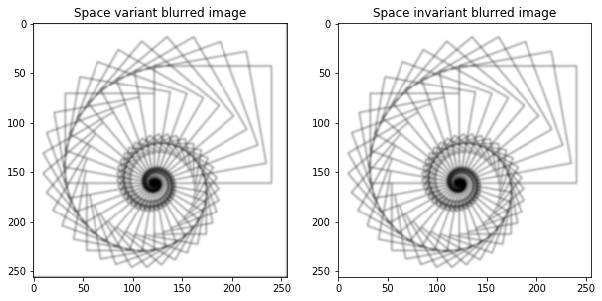

In [7]:
# Compute the output from both blurring functions(space-variant and space-invariant) with sigma = 1.0 
img = cv2.imread('Nautilus.png',0)
space_var_blurred_img = space_var_blur(img, sig = sig2)
sigma1_kernel = get_kernel(sigma=1.) # kernel with sigma = 1.0
space_inv_blurred_img = space_invariant_blur(img, sigma1_kernel)

# Show the space-variant and space-invariant blurred images.
f, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].set_title("Space variant blurred image")
axs[1].set_title("Space invariant blurred image")
axs[0].imshow(space_var_blurred_img,cmap='gray')
axs[1].imshow(space_inv_blurred_img,cmap='gray')
plt.show()

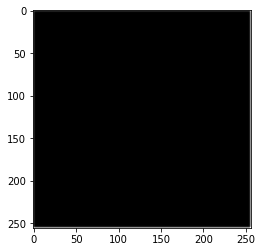

In [8]:
# Compute the difference between the 2 blurred images
plt.imshow(space_inv_blurred_img - space_var_blurred_img, cmap = 'gray')

We can see that both images are identical since their difference is zero.